In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import SGD

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\FileBase")

from root_functions import add_indicators, up_down, full_prediction, full_prediction_binary, result

## Descarga datos y creación dataset

In [3]:
sample_per = 500
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1d'

In [4]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [5]:
#Añadimos indicadores

ema1=200
ema2=50
ema3=20

data_base = add_indicators(database)

#Añadimos columna up_down
data_base = up_down(data_base)

#Listado indicadores
data_base.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'log_ret', 'Up_Down'],
      dtype='object')

In [6]:
#Hacemos un shift a la columna Up_Down para tener el signo de la tendencia de la siguiente vela
data_base['Up_Down'] = data_base['Up_Down'].shift(-1)

data_base.dropna(inplace=True)

In [7]:
#Filtramos las columnas que nos interesan para obtener el dataset de trabajo
db = data_base.copy()

#f'{ema1}ema', f'{ema2}ema', f'{ema3}ema'
data = db[['Up_Down','200ema',
       '50ema', '20ema', '14-high', '14-low', '%K', '%D', 'RSI', 'MACD',
       'MACDh', 'MACDs', 'CCI', 'PSAR', 'BBl', 'BBm', 'BBu', 'BBb', 'BBp',
       'ATR', 'log_ret']]


cols = data.columns

In [8]:
data.columns[0]

'Up_Down'

In [9]:
data.reset_index(inplace=True)
data.drop(columns=data.columns[0], inplace=True)

C:\Users\Usuario\anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Preparacion datos para el LSTM

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Up_Down  325 non-null    float64
 1   200ema   325 non-null    float64
 2   50ema    325 non-null    float64
 3   20ema    325 non-null    float64
 4   14-high  325 non-null    float64
 5   14-low   325 non-null    float64
 6   %K       325 non-null    float64
 7   %D       325 non-null    float64
 8   RSI      325 non-null    float64
 9   MACD     325 non-null    float64
 10  MACDh    325 non-null    float64
 11  MACDs    325 non-null    float64
 12  CCI      325 non-null    float64
 13  PSAR     325 non-null    float64
 14  BBl      325 non-null    float64
 15  BBm      325 non-null    float64
 16  BBu      325 non-null    float64
 17  BBb      325 non-null    float64
 18  BBp      325 non-null    float64
 19  ATR      325 non-null    float64
 20  log_ret  325 non-null    float64
dtypes: float64(21)
m

In [11]:
#Convertimos todas las columnas a valor numerico
data = data.apply(pd.to_numeric)


#Escalamos los valores con un MinMaxScaler
values = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

values = scaled


#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
print(train_X.shape, val_X.shape, test_X.shape, train_y.shape, val_y.shape, test_y.shape)

(260, 20) (32, 20) (33, 20) (260,) (32,) (33,)


## Creamos el modelo

In [12]:
n_features = train_X.shape[1]
n_features

20

In [13]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(Dense(256, activation='relu',   kernel_initializer='he_normal', input_shape=(n_features,)))



model.add(Dense(256, activation='relu'))



model.add(Dense(1, activation='sigmoid'))




In [14]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 71,425
Trainable params: 71,425
Non-trainable params: 0
_________________________________________________________________


In [16]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=25, batch_size = train_X.shape[0], validation_data=(val_X, val_y), verbose=0)

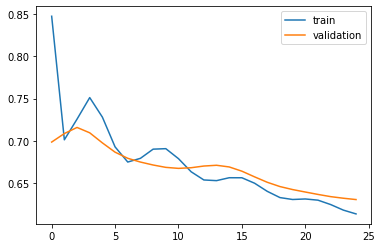

In [17]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()



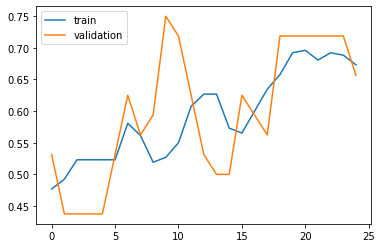

In [18]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [19]:
# evaluate the model
loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %.5f' % acc)
print('Test Loss: %.5f' % loss)

Test Accuracy: 0.45455
Test Loss: 0.70630


## Resultados con valores de test

In [20]:
# make a prediction
yhat = model.predict(test_X)

In [21]:
inv_yhat = np.concatenate((yhat, test_X), axis=1)
test_y_re = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y_re, test_X), axis=1)


inv_yhat = scaler.inverse_transform(inv_yhat)
inv_y = scaler.inverse_transform(inv_y)


inv_yhat_df = pd.DataFrame(data=inv_yhat, columns=cols)
inv_y_df = pd.DataFrame(data=inv_y, columns=cols)

In [22]:
inv_y_df

,Up_Down,200ema,50ema,20ema,14-high,14-low,%K,%D,RSI,MACD,...,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,log_ret
0,1.0,0.871583,0.858789,0.856472,0.86404,0.85044,56.323355,39.157716,51.953169,-0.001168,...,-0.001219,106.752918,0.850440,0.850867,0.854560,0.858253,0.864213,0.979336,0.005018,0.004695
1,1.0,0.871490,0.858939,0.857056,0.86691,0.85044,73.831427,54.151773,58.813013,-0.000539,...,-0.001083,201.152823,0.850712,0.848895,0.856240,0.863585,1.715747,0.932923,0.005289,0.005244
2,0.0,0.871413,0.859138,0.857720,0.86691,0.85044,82.513752,70.889512,60.731637,0.000074,...,-0.000851,155.900692,0.851360,0.850017,0.858504,0.866991,1.977195,0.825551,0.005227,0.001658
3,0.0,0.871293,0.859165,0.857919,0.86691,0.85044,56.891285,71.078822,52.899959,0.000217,...,-0.000638,37.568989,0.851982,0.852729,0.859726,0.866723,1.627764,0.506002,0.005498,-0.004884
4,1.0,0.871121,0.858989,0.857611,0.86691,0.85044,25.804502,55.069847,45.271990,-0.000082,...,-0.000527,-27.663477,0.852579,0.853229,0.859846,0.866463,1.539024,0.110376,0.005470,-0.005955
5,0.0,0.870963,0.858864,0.857439,0.86691,0.85044,32.543790,38.413192,47.054395,-0.000226,...,-0.000467,-35.145402,0.853152,0.852065,0.859386,0.866707,1.703674,0.255072,0.005331,0.001299
6,0.0,0.870785,0.858663,0.857087,0.86691,0.85044,20.036190,26.128161,44.178629,-0.000502,...,-0.000474,-76.732201,-0.866910,0.849981,0.857614,0.865247,1.780147,0.246246,0.005262,-0.002407
7,1.0,0.870586,0.858380,0.856549,0.86691,0.84990,9.053543,20.544507,41.154436,-0.000895,...,-0.000558,-112.121337,-0.866600,0.849576,0.855096,0.860616,1.291069,0.168839,0.005160,-0.002694
8,0.0,0.870390,0.858114,0.856078,0.86691,0.84990,9.994043,13.027925,41.454639,-0.001180,...,-0.000682,-99.752260,-0.865932,0.850036,0.853454,0.856872,0.801068,0.228818,0.004933,0.000188
9,1.0,0.870195,0.857855,0.855642,0.86691,0.84990,9.406055,9.484547,41.312740,-0.001398,...,-0.000825,-76.196529,-0.865291,0.849368,0.852816,0.856264,0.808639,0.309169,0.004752,-0.000117


In [23]:
inv_yhat_df

,Up_Down,200ema,50ema,20ema,14-high,14-low,%K,%D,RSI,MACD,...,MACDs,CCI,PSAR,BBl,BBm,BBu,BBb,BBp,ATR,log_ret
0,0.658237,0.871583,0.858789,0.856472,0.86404,0.85044,56.323355,39.157716,51.953169,-0.001168,...,-0.001219,106.752918,0.850440,0.850867,0.854560,0.858253,0.864213,0.979336,0.005018,0.004695
1,0.678731,0.871490,0.858939,0.857056,0.86691,0.85044,73.831427,54.151773,58.813013,-0.000539,...,-0.001083,201.152823,0.850712,0.848895,0.856240,0.863585,1.715747,0.932923,0.005289,0.005244
2,0.604999,0.871413,0.859138,0.857720,0.86691,0.85044,82.513752,70.889512,60.731637,0.000074,...,-0.000851,155.900692,0.851360,0.850017,0.858504,0.866991,1.977195,0.825551,0.005227,0.001658
3,0.601745,0.871293,0.859165,0.857919,0.86691,0.85044,56.891285,71.078822,52.899959,0.000217,...,-0.000638,37.568989,0.851982,0.852729,0.859726,0.866723,1.627764,0.506002,0.005498,-0.004884
4,0.679004,0.871121,0.858989,0.857611,0.86691,0.85044,25.804502,55.069847,45.271990,-0.000082,...,-0.000527,-27.663477,0.852579,0.853229,0.859846,0.866463,1.539024,0.110376,0.005470,-0.005955
5,0.698420,0.870963,0.858864,0.857439,0.86691,0.85044,32.543790,38.413192,47.054395,-0.000226,...,-0.000467,-35.145402,0.853152,0.852065,0.859386,0.866707,1.703674,0.255072,0.005331,0.001299
6,0.592764,0.870785,0.858663,0.857087,0.86691,0.85044,20.036190,26.128161,44.178629,-0.000502,...,-0.000474,-76.732201,-0.866910,0.849981,0.857614,0.865247,1.780147,0.246246,0.005262,-0.002407
7,0.612779,0.870586,0.858380,0.856549,0.86691,0.84990,9.053543,20.544507,41.154436,-0.000895,...,-0.000558,-112.121337,-0.866600,0.849576,0.855096,0.860616,1.291069,0.168839,0.005160,-0.002694
8,0.617480,0.870390,0.858114,0.856078,0.86691,0.84990,9.994043,13.027925,41.454639,-0.001180,...,-0.000682,-99.752260,-0.865932,0.850036,0.853454,0.856872,0.801068,0.228818,0.004933,0.000188
9,0.631102,0.870195,0.857855,0.855642,0.86691,0.84990,9.406055,9.484547,41.312740,-0.001398,...,-0.000825,-76.196529,-0.865291,0.849368,0.852816,0.856264,0.808639,0.309169,0.004752,-0.000117


In [24]:
res = pd.DataFrame({'yhat':inv_yhat[:,0], 'y':inv_y[:,0]})


lista =[]
for index, row in res.iterrows():
    if ((row['yhat'] > 0.5) and (row['y'] == 1)):
        lista.append('Acierto')
        
    elif ((row['yhat'] < 0.5) and (row['y'] == 0)):
        lista.append('Acierto')
    
    else:
        lista.append('Error')

serie = pd.Series(lista, index = res.index)

res['Resultado'] = serie



In [25]:
print(res['Resultado'].value_counts())
print()
per = res['Resultado'].value_counts()[0]/(res['Resultado'].value_counts()[1]+res['Resultado'].value_counts()[0])
print(f'% acierto: {per}')

Error      18
Acierto    15
Name: Resultado, dtype: int64

% acierto: 0.5454545454545454


In [26]:
res

,yhat,y,Resultado
0,0.658237,1.0,Acierto
1,0.678731,1.0,Acierto
2,0.604999,0.0,Error
3,0.601745,0.0,Error
4,0.679004,1.0,Acierto
5,0.698420,0.0,Error
6,0.592764,0.0,Error
7,0.612779,1.0,Acierto
8,0.617480,0.0,Error
9,0.631102,1.0,Acierto
